<a href="https://colab.research.google.com/github/SevikoA3/Spoofing-Research/blob/main/DFNets_no_crop_CBAM_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DFNets with CBAM Fusion for Face Anti-Spoofing

This notebook implements a deep learning model for face anti-spoofing using DFNets architecture with CBAM (Convolutional Block Attention Module) fusion mechanism on the OULU-NPU dataset.

In [23]:
import logging, os
import tensorflow as tf
print(tf.__version__)

import random
import pathlib
import glob

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

import pandas as pd
from pathlib import Path

# harus keras version 3.8
from tensorflow.keras import layers

import random
import tensorflow as tf

2.18.0


In [24]:
SEED = 42
# os.environ['PYTHONHASHSEED'] = str(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'  # penting untuk determinisme op tf
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [25]:
class VideoFramesDataset:
    def __init__(self, root_dir, annotation_file, n_frames=10, transform=False):
        self.root_dir = root_dir
        self.transform = transform
        self.n_frames = n_frames
        #self._parse_annotationfile()

        self.video_list = annotation_file[0]
        self.label = annotation_file[0]

    def __len__(self):
        return len(self.video_list)

    def on_epoch_end(self):
        pass

    def  __call__(self):
        for idx in range(len(self.video_list)):
            frame = np.load(os.path.join(self.root_dir, self.video_list[idx][3:]+".npy"))
            #frame = frames_from_video_file(os.path.join(self.root_dir, self.video_list[idx][3:]+".avi"), 20, output_size = (224,224), frame_step = 15)

            # Sample n_frames frames from the available frames
            total_frames = frame.shape[0]
            if total_frames >= self.n_frames:
                # Sample n_frames frames evenly distributed across the video
                indices = np.linspace(0, total_frames-1, self.n_frames, dtype=int)
                frame = frame[indices]  # Shape: (n_frames, 224, 224, 3)
            else:
                # If less than n_frames frames, repeat the last frame
                needed_frames = self.n_frames - total_frames
                last_frame = frame[-1:].repeat(needed_frames, axis=0)
                frame = np.concatenate([frame, last_frame], axis=0)

            #print(frame.dtype)
            if self.label[idx][0] == "+":
                label = tf.convert_to_tensor([0])
            else:
                label = tf.convert_to_tensor([1])
            #label = tf.convert_to_tensor(int(self.label[idx][-1])-1)
            yield tf.convert_to_tensor(frame, dtype=tf.float32), (label, label, label)

In [26]:
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
n_frames = 10
batch_size = 12

AUTOTUNE = tf.data.AUTOTUNE
#path = "G:/My Drive/Pindahan"
path = "/content/drive/My Drive"
# path = "."

# def augmentation(frame):
#   # contrast
#   # brightness
#   #gamma = np.random.uniform(low=0.5,high=0.8,size=[1,])
#   #frame = tf.image.adjust_gamma(frame, gamma[0], 1)
#   frame = tf.image.random_contrast(frame,0,2)
#   frame = tf.image.random_flip_left_right(frame)
#   frame = tf.image.random_brightness(frame,0.1)
#   #frame = tf.image.resize(frame,(448,tf.random.uniform([1],180,200,dtype=tf.int32)[0]))
#   #frame = tf.image.resize_with_crop_or_pad(frame,224,224)
#   return frame

def augmentation(color_image):
    color_image = tf.image.random_brightness(color_image, max_delta=0.1, seed=SEED)
    color_image = tf.image.random_contrast(color_image, 0, 2, seed=SEED)
    # color_image = tf.image.random_saturation(color_image, lower=0.8, upper=1.2, seed=SEED)
    # color_image = tf.image.random_hue(color_image, max_delta=0.2, seed=SEED)
    color_image = tf.image.random_flip_left_right(color_image, seed=SEED)
    # rot_k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32, seed=42)

    # def rotate(frame):
    #     frame = tf.image.rot90(frame, k=rot_k)
    #     return frame

    # color_image = tf.map_fn(rotate, color_image)
    color_image = tf.clip_by_value(color_image, 0.0, 1.0)
    return color_image

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.4, seed=SEED),
    tf.keras.layers.RandomBrightness(0.2, value_range=(0, 1), seed=SEED),
    tf.keras.layers.RandomRotation(0.111, seed=SEED),
    tf.keras.layers.RandomTranslation(0.2, 0.2, seed=SEED),
    tf.keras.layers.RandomZoom(0.2, seed=SEED),
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
])

In [28]:
train_dir = path+"/OULU-NPU/Train_files/Train_files/output/"
dev_dir = path+"/OULU-NPU/Dev_files/Dev_files/output/"
test_dir = path+"/OULU-NPU/Test_files/Test_files/output/"

#train_dir = path+"/Limited Source/O to I and M/Train OULU/Step 4/"
#train_annotation = pd.read_csv(os.path.join(path,"OULU-NPU/Train_files/Train_files/output", "annotation.txt"), sep = ' ', header=None).sample(frac=0.5, replace=None, weights=None, random_state=42, axis=None, ignore_index=True)

train_annotation = pd.read_csv(os.path.join(path, "OULU-NPU/Protocols/Protocols/Protocol_1/Train.txt"), sep = ' ', header=None)
dev_annotation = pd.read_csv(os.path.join(path, "OULU-NPU/Protocols/Protocols/Protocol_1/Dev.txt"), sep = ' ', header=None)
test_annotation = pd.read_csv(os.path.join(path, "OULU-NPU/Protocols/Protocols/Protocol_1/Test.txt"), sep = ' ', header=None)
#.sample(frac=0.5, replace=False, weights=None, axis=None, ignore_index=True)

In [29]:
# Debug: Check the actual shape of loaded data
import os
sample_file = train_annotation.iloc[0, 0]  # Get first video filename
print(f"Sample filename: {sample_file}")

# Load and check shape
sample_data = np.load(os.path.join(train_dir, sample_file[3:] + ".npy"))
print(f"Original shape: {sample_data.shape}")
print(f"Data type: {sample_data.dtype}")

# Try different transpose operations
print("\nTesting transpose operations:")
print(f"axes=[0,1,2,3] -> {np.transpose(sample_data, axes=[0,1,2,3]).shape}")
print(f"axes=[1,2,3,0] -> {np.transpose(sample_data, axes=[1,2,3,0]).shape}")
print(f"axes=[3,0,1,2] -> {np.transpose(sample_data, axes=[3,0,1,2]).shape}")
print(f"axes=[3,1,2,0] -> {np.transpose(sample_data, axes=[3,1,2,0]).shape}")

# We need shape (n_frames, 224, 224, 3)

Sample filename: +1,1_1_01_1
Original shape: (151, 224, 224, 3)
Data type: uint8

Testing transpose operations:
axes=[0,1,2,3] -> (151, 224, 224, 3)
axes=[1,2,3,0] -> (224, 224, 3, 151)
axes=[3,0,1,2] -> (3, 151, 224, 224)
axes=[3,1,2,0] -> (3, 224, 224, 151)


In [30]:
# Test the VideoFramesDataset generator
test_dataset = VideoFramesDataset(train_dir, train_annotation, n_frames)
test_gen = test_dataset()

# Get first sample
sample_x, sample_y = next(test_gen)
print(f"Generated shape: {sample_x.shape}")
print(f"Expected shape: ({n_frames}, 224, 224, 3)")
print(f"Label shape: {sample_y[0].shape}")

# Verify it matches our output signature
print(f"Shape matches expectation: {sample_x.shape == (n_frames, 224, 224, 3)}")

Generated shape: (10, 224, 224, 3)
Expected shape: (10, 224, 224, 3)
Label shape: (1,)
Shape matches expectation: True


In [31]:
output_signature = (
    tf.TensorSpec(shape=(n_frames, 224, 224, 3), dtype=tf.float32),  # input video frames
    (
        tf.TensorSpec(shape=(1,), dtype=tf.int32),  # for output
        tf.TensorSpec(shape=(1,), dtype=tf.int32),  # for gap
        tf.TensorSpec(shape=(1,), dtype=tf.int32),  # for gap_saliency
    )
)

train_ds_oulu = tf.data.Dataset.from_generator(VideoFramesDataset(train_dir, train_annotation, n_frames), output_signature = output_signature)
train_ds_oulu = train_ds_oulu.shuffle(32, seed=SEED, reshuffle_each_iteration=True)
train_ds_oulu = train_ds_oulu.map(lambda x, y: (augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_oulu = train_ds_oulu.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache().repeat()

dev_ds_oulu = tf.data.Dataset.from_generator(VideoFramesDataset(dev_dir, dev_annotation, n_frames), output_signature = output_signature)
dev_ds_oulu = dev_ds_oulu.shuffle(32).batch(batch_size).prefetch(AUTOTUNE)

test_ds_oulu = tf.data.Dataset.from_generator(VideoFramesDataset(test_dir, test_annotation, n_frames), output_signature = output_signature)
test_ds_oulu = test_ds_oulu.batch(batch_size).prefetch(AUTOTUNE)

In [32]:
# ===================== NON-OULU DATASET CODE (COMMENTED OUT) =====================
# class VideoFramesDatasetMSU:
#     def __init__(self, root_dir, annotation_file, transform=False):
#         self.root_dir = root_dir
#         self.transform = transform
#         #self._parse_annotationfile()
#
#         self.video_list = annotation_file[0]
#         self.label = annotation_file[1]
#
#     def __len__(self):
#         return len(self.video_list)
#
#     def on_epoch_end(self):
#         pass
#
#     def  __call__(self):
#         for idx in range(len(self.video_list)):
#             frame = np.load(os.path.join(self.root_dir, self.video_list[idx]))
#             #frame = (frame-frame.mean())/frame.std()
#             frame = np.transpose(frame, axes=[0, 2, 3, 1])
#             if self.label[idx] == 0:
#                 label = tf.convert_to_tensor(0)
#             else:
#                 label = tf.convert_to_tensor(1)
#
#             label = tf.convert_to_tensor([label])
#
#             yield tf.convert_to_tensor(frame), label
#
# test_dir_msu = path+"/MSU-MFSD/MSU-MFSD-Publish.zip/scene01/output/"
# #test_dir_msu = "./Limited Source/O to I and M/Test MSU-MFSD/Step 2/"
#
# test_annotation_msu = pd.read_csv(path+"/MSU-MFSD/MSU-MFSD-Publish.zip/scene01/output/annotation.txt", sep = ',', header=None)
# selection = pd.read_csv(path+"/MSU-MFSD/MSU-MFSD-Publish.zip/test_sub_list.txt", header=None).values[:,0].astype("str").tolist()
# selection = ['0' + s if len(s)>1 else '00'+s for s in selection]
# test_annotation_msu = test_annotation_msu[test_annotation_msu.iloc[:,[0]].squeeze().str.contains('|'.join(selection))].reset_index().iloc[:,1:]
#
# output_signature = (
#     tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # video frame sequence
#     tf.TensorSpec(shape=(1,), dtype=tf.int32)                    # batch of 1 label
#     )
#
# val_ds_msu = tf.data.Dataset.from_generator(VideoFramesDatasetMSU(test_dir_msu, test_annotation_msu), output_signature = output_signature)
# val_ds_msu = val_ds_msu.batch(batch_size).prefetch(AUTOTUNE)
#
# class VideoFramesDatasetIdiap:
#     def __init__(self, root_dir, annotation_file):
#         self.root_dir = root_dir
#         #self._parse_annotationfile()
#
#         self.video_list = annotation_file[0]
#         self.label = annotation_file[1]
#
#     def __len__(self):
#         return len(self.video_list)
#
#     def on_epoch_end(self):
#         pass
#
#     def  __call__(self):
#         for idx in range(len(self.video_list)):
#             frame = np.load(os.path.join(self.root_dir, self.video_list[idx]))
#             frame = np.transpose(frame, axes=[0, 2, 3, 1])
#             # frame = exposure.adjust_gamma(frame, 0.5)
#             if self.label[idx] == 0:
#                 label = tf.convert_to_tensor(0)
#             else:
#                 label = tf.convert_to_tensor(1)
#
#             label = tf.convert_to_tensor([label])
#
#             yield tf.convert_to_tensor(frame), label
#
# test_dir_idiap = path+"/Idiap/replayattack-test.tar.gz/test/output/"
# #test_dir_idiap = path+"/Limited Source/O to I and M/Test Idiap/Step 4/"
# test_annotation_idiap = pd.read_csv(path+"/Idiap/replayattack-test.tar.gz/test/output/annotation.txt", sep = ',', header=None)
#
# train_dir_idiap = path+"/Idiap/replayattack-train.tar.gz/train/output/"
# train_annotation_idiap = pd.read_csv(train_dir_idiap+"/annotation.txt", sep = ',', header=None)
#
# train_ds_idiap = tf.data.Dataset.from_generator(VideoFramesDatasetIdiap(train_dir_idiap, train_annotation_idiap), output_signature = output_signature)
# train_ds_idiap = train_ds_idiap.batch(batch_size)
# train_ds_idiap = train_ds_idiap.prefetch(AUTOTUNE)
#
# val_ds_idiap = tf.data.Dataset.from_generator(VideoFramesDatasetIdiap(test_dir_idiap, test_annotation_idiap), output_signature = output_signature)
# val_ds_idiap = val_ds_idiap.batch(batch_size).prefetch(AUTOTUNE)
# ===================== END NON-OULU DATASET CODE =====================

In [33]:
class SpatialAttentionModule(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def build(self, input_shape):
        super().build(input_shape)
        # Build the conv layer with proper input shape
        self.conv.build(input_shape[:-1] + (2,))  # 2 channels for avg and max

    def compute_output_shape(self, input_shape):
        # input_shape: (B, H, W, C)
        # output: same spatial dims, last channel = 1
        return input_shape[:-1] + (1,)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_out = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        return self.conv(concat)

In [34]:
# """# Create Model""
def build_dfnet_model(video_input, base_filters=32):

    # Shared feature extractor for each frame
    base_cnn = tf.keras.applications.ResNet50(
        include_top=False, input_shape=(224, 224, 3), weights="imagenet"
    )
    base_cnn.trainable = True

    # Choose a mid-layer to cut at
    #truncated_base = Model(inputs=base_cnn.input, outputs=base_cnn.get_layer("block_5_add").output)

    base_cnn_saliency = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=(224, 224, 3), weights="imagenet"
    )
    base_cnn_saliency.trainable = True

    #truncated_saliency = Model(inputs=base_cnn_saliency.input, outputs=base_cnn_saliency.get_layer("block3a_activation").output)

    feature_extractor = tf.keras.Sequential([
        # layers.Rescaling(scale=255),
        base_cnn
        # truncated_base
    ])

    feature_extractor_saliency = tf.keras.Sequential([
        # layers.Rescaling(scale=255),
        base_cnn_saliency
        # truncated_saliency
    ])

    # Process each frame
    features = layers.TimeDistributed(feature_extractor)(video_input)  # (B, N, 7, 7, F)
    # features = layers.TimeDistributed(layers.UpSampling2D(size=(2, 2)))(features)

    # Generate occlusion mask
    # masks = cefe_attention_module(features_0)
    # masks = layers.TimeDistributed(saliency_branch)(features_0)  # (B, N, H, W, 3)
    # saliency_masks = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(features)  # (B, N, 7, 7, 1)

    saliency_masks = layers.TimeDistributed(SpatialAttentionModule())(features)

    # Resize masks to (224, 224)
    saliency_masks = layers.TimeDistributed(
        layers.Resizing(224, 224, interpolation='bilinear')
    )(saliency_masks)  # (B, N, 224, 224, 1)

    # Normalize to [0, 1]
    saliency_masks = layers.Lambda(lambda x: (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x) + 1e-6))(saliency_masks)

    # masks = layers.UpSampling3D((1,32,32))(masks)
    #saliency_masks = layers.Lambda(lambda x: 1.0 - x)(saliency_masks)  # invert --> masks = 1-masks

    epsilon = 0.1  # Avoid fully black regions
    soft_mask = layers.Lambda(lambda x: tf.clip_by_value(1.0 - x, epsilon, 1.0))(saliency_masks)

    # Apply occlusion
    masked_input = layers.Multiply()([video_input, soft_mask])

    features_saliency = layers.TimeDistributed(feature_extractor_saliency)(masked_input)  # (B, N, 7, 7, F)

    drop = layers.Dropout(0.3)(features)
    dense = layers.Dense(1, name="dense")(drop)
    gap = layers.GlobalAveragePooling3D(name="out")(dense)

    drop_saliency = layers.Dropout(0.3)(features_saliency)
    dense_saliency = layers.Dense(1, name="dense_saliency")(drop_saliency)
    gap_saliency = layers.GlobalAveragePooling3D(name='out_sal')(dense_saliency)

    # Inject contrastive loss

    return features, features_saliency, gap, gap_saliency, saliency_masks

In [35]:
@tf.keras.utils.register_keras_serializable(package="channel_att")
class channel_attention(tf.keras.layers.Layer):
    """
    channel attention module

    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    def __init__(self, ratio=8, **kwargs):
        super(channel_attention, self).__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super(channel_attention, self).get_config()
        config.update({'ratio': self.ratio})
        return config

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_layer_one = tf.keras.layers.Dense(
            channel // self.ratio,
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        self.shared_layer_two = tf.keras.layers.Dense(
            channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros'
        )
        super(channel_attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        channel = inputs.get_shape().as_list()[-1]

        avg_pool = tf.keras.layers.GlobalAveragePooling3D()(inputs)
        avg_pool = tf.keras.layers.Reshape((1, 1, 1, channel))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        max_pool = tf.keras.layers.GlobalMaxPooling3D()(inputs)
        max_pool = tf.keras.layers.Reshape((1, 1, 1, channel))(max_pool)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        feature = tf.keras.layers.Add()([avg_pool, max_pool])
        feature = tf.keras.layers.Activation('sigmoid')(feature)

        return tf.keras.layers.multiply([inputs, feature])

In [36]:
@tf.keras.utils.register_keras_serializable(package="spatial_att")
class spatial_attention(tf.keras.layers.Layer):
    """ spatial attention module

    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    def __init__(self, kernel_size=7, **kwargs):
        super(spatial_attention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def get_config(self):
        config = super(spatial_attention, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

    def build(self, input_shape):
        self.conv3d = tf.keras.layers.Conv3D(
            filters=1,
            kernel_size=self.kernel_size,
            strides=1,
            padding='same',
            activation='sigmoid',
            kernel_initializer='he_normal',
            use_bias=False
        )
        super(spatial_attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, inputs):
        avg_pool = tf.keras.layers.Lambda(
            lambda x: tf.keras.backend.mean(x, axis=-1, keepdims=True)
        )(inputs)
        max_pool = tf.keras.layers.Lambda(
            lambda x: tf.keras.backend.max(x, axis=-1, keepdims=True)
        )(inputs)
        concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
        feature = self.conv3d(concat)

        return tf.keras.layers.multiply([inputs, feature])

In [37]:
@tf.keras.utils.register_keras_serializable(package="cbam_block", name="cbam")
def cbam_block(feature, ratio=8, kernel_size=7):
    """
    Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    feature = channel_attention(ratio=ratio)(feature)
    feature = spatial_attention(kernel_size=kernel_size)(feature)

    return feature

In [38]:
# PsiNet with CBAM
def psi_net(input_tensor, additional_inputs, ratio=8, kernel_size=7):
    """Enhanced PsiNet Block with CBAM Attention and Dynamic Coefficients"""
    # Convolutional layers with residual connection
    x = layers.TimeDistributed(layers.Conv2D(32, (3, 3), padding='same'))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual connection
    shortcut = (
        layers.TimeDistributed(layers.Conv2D(32, (1, 1), padding='same'))(input_tensor)
        if x.shape[-1] != input_tensor.shape[-1] else input_tensor
    )
    x = layers.Add()([x, shortcut])

    # CBAM attention
    x = cbam_block(x, ratio=ratio, kernel_size=kernel_size)

    # Dynamic weighting for fusion
    num_additional_inputs = len(additional_inputs)
    coeffs = layers.Dense(num_additional_inputs + 1, activation='softmax', kernel_initializer='he_uniform')(
        layers.GlobalAveragePooling3D()(x)
    )

    # Reshape coeffs for broadcasting
    coeffs = layers.Lambda(
        lambda c: tf.expand_dims(tf.expand_dims(tf.expand_dims(c, 1), 1), 1),
        output_shape=(None, 1, 1, 1, num_additional_inputs + 1),
    )(coeffs)
    # coeffs shape: [batch_size, 1, 1, 1, num_additional_inputs + 1]

    # Use Lambda to dynamically broadcast `coeffs` to match `x`
    coeffs = layers.Lambda(
        lambda args: tf.broadcast_to(
            args[0],
            [tf.shape(args[1])[0], tf.shape(args[1])[1], tf.shape(args[1])[2], tf.shape(args[1])[3], tf.shape(args[0])[-1]],
        ),
        output_shape=(None, None, None, None, num_additional_inputs + 1),
    )([coeffs, x])

    # Fuse inputs dynamically
    fused = layers.Lambda(
        lambda args: args[0] * args[1],
        output_shape=x.shape[1:],  # Shape of `x` remains unchanged
    )([coeffs[..., 0:1], x])  # coeffs[..., 0:1] matches x's shape

    for i, add_input in enumerate(additional_inputs):
        # Align channel dimensions of additional inputs
        reduced_input = layers.TimeDistributed(layers.Conv2D(32, (1, 1), padding='same'))(add_input)
        # fused = layers.Lambda(
        #     lambda args: args[0] + args[1] * args[2],
        #     output_shape=fused.shape[1:],  # Shape of `fused` remains unchanged
        # )([fused, coeffs[..., i + 1:i + 2], reduced_input])
        # Weighted additional input
        weighted_input = layers.Lambda(
            lambda args: args[0] * args[1],
            output_shape=reduced_input.shape[1:],  # (Time, H, W, C)
        )([coeffs[..., i + 1:i + 2], reduced_input])

    # Concatenate along the channel axis (-1)
    fused = layers.Concatenate(axis=-1)([fused, weighted_input])

    fused = tf.keras.layers.BatchNormalization()(fused)

    return fused

In [39]:
video_input = tf.keras.Input(shape=(n_frames, 224, 224, 3))  # (N, 224, 224, 3)

features, features_saliency, gap, gap_saliency, _ = build_dfnet_model(video_input, base_filters=32)

# Fusion
fusion = psi_net(features, [features_saliency])  # (B, N, 2F)
drop = layers.Dropout(0.3)(fusion)
dense = layers.Dense(32, activation='relu')(drop)
gap_fusion = layers.GlobalAveragePooling3D()(dense)
output = layers.Dense(1, name='fusion')(gap_fusion)

In [40]:
class ContrastiveDiversityLossLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_div=0.01, **kwargs):
        super().__init__(**kwargs)
        self.lambda_div = lambda_div

    def call(self, inputs):
        gap1, gap2 = inputs
        # loss = -tf.reduce_mean(tf.square(gap1 - gap2))  # encourage dissimilarity
        loss = tf.keras.losses.cosine_similarity(gap1,gap2) + 1
        self.add_loss(self.lambda_div * loss)
        return gap1  # or gap2, or just pass it through if needed

# gap = ContrastiveDiversityLossLayer(lambda_div=0.01, name = 'out_ori')([gap, gap_saliency])

In [41]:
from tensorflow.keras.losses import BinaryFocalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import AUC

# Hyperparameter for contrastive weight
lambda_div = 0.01

# Define focal loss
focal_loss_fn = BinaryFocalCrossentropy(from_logits=True)

# Define model
model = tf.keras.Model(inputs=video_input, outputs=[output, gap, gap_saliency])

# Use focal loss for the fusion output only
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1 = 0.9, weight_decay = 0.0005),
    loss={
        "fusion": focal_loss_fn,
        "out": focal_loss_fn,
        "out_sal": focal_loss_fn
        },  # you can ignore gap/gap_saliency for direct supervision
    metrics={"fusion": AUC(from_logits=True, name="auc")}
)

In [42]:
model.summary()

dummy_input = tf.zeros((1, n_frames, 224, 224, 3))  # Adjust shape as needed
_ = model(dummy_input)  # This will build the model

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 10, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 10, 7, 7,  │ 23,587,712 │ input_layer_5[0]… │
│ (TimeDistributed)   │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 10, 7, 7,  │    589,856 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 7, 7,  │        128 │ time_distributed… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 10, 7, 7,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 10, 7, 7,  │     65,568 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 7, 7,  │          0 │ re_lu_1[0][0],    │
│                     │ 32)               │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_attention_1 │ (None, 10, 7, 7,  │          0 │ add_4[0][0]       │
│ (channel_attention) │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 10, 7, 7,  │         99 │ time_distributed… │
│ (TimeDistributed)   │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention_1 │ (None, 10, 7, 7,  │          0 │ channel_attentio… │
│ (spatial_attention) │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 10, 224,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ spatial_attentio… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 10, 224,   │          0 │ time_distributed… │
│                     │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 10, 224,   │          0 │ lambda_12[0][0]   │
│                     │ 224, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, None, 1,   │          0 │ dense_6[0][0]     │
│                     │ 1, 1, 2)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 10, 224,   │          0 │ input_layer_5[0]… │
│ (Multiply)          │ 224, 3)           │            │ lambda_13[0][0] 

 Total params: 28,339,691 (108.11 MB)

 Trainable params: 28,244,356 (107.74 MB)

 Non-trainable params: 95,335 (372.41 KB)

In [43]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "dfnet_best_model_contrastive_protocol_3_f.weights.h5",
    monitor="val_fusion_auc",
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_fusion_auc",
    patience=10,
    restore_best_weights=True,
    mode="max"
)

lr_reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_fusion_auc",
    factor=0.8,
    patience=5,
    min_lr=1e-6,
    mode="max"
)

In [44]:
# model.load_weights("dfnet_best_model_contrastive_epoch_60.weights.h5")
# model.load_weights("dfnet_best_model_contrastive protocol_1_no_crop_fusion_3.weights.h5")
history = model.fit(
    train_ds_oulu,
    #validation_data=test_ds_oulu,
    epochs=20,
    steps_per_epoch=125,
    #callbacks=[checkpoint_cb],
    verbose=1
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1868s 9s/step - fusion_auc: 0.6075 - fusion_loss: 0.2224 - loss: 0.5320 - out_loss: 0.1744 - out_sal_loss: 0.1352
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 296ms/step - fusion_auc: 0.7965 - fusion_loss: 0.0964 - loss: 0.3006 - out_loss: 0.1103 - out_sal_loss: 0.0939
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - fusion_auc: 0.8379 - fusion_loss: 0.0855 - loss: 0.2564 - out_loss: 0.0912 - out_sal_loss: 0.0797
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - fusion_auc: 0.8761 - fusion_loss: 0.0743 - loss: 0.2240 - out_loss: 0.0773 - out_sal_loss: 0.0724
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 298ms/step - fusion_auc: 0.9128 - fusion_loss: 0.0648 - loss: 0.1999 - out_loss: 0.0692 - out_sal_loss: 0.0659
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - fusion_auc: 0.9132 - fusion_loss: 0.0623 - loss: 0.1888 - out_loss: 0.0640 - out_sal_loss: 0.0626
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 298ms/step - fusion_auc: 0.

In [45]:
model.save_weights("dfnet_best_model_contrastive protocol_1_no_crop_fusion_3.weights.h5")
# model.load_weights("dfnet_best_model_contrastive_protocol_3_f.weights.h5")

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

y_pred_keras,_,_ = model.predict(test_ds_oulu)
y_pred_keras = y_pred_keras.ravel()

y_test = []
for idx in range(len(y_pred_keras)):
    if test_annotation[0][idx][0] == '+': # 0 as genuine
        y_test.extend([0])
    else:
        y_test.extend([1])  # 1 as fake

y_test = np.array(y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 673s 11s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [47]:
fpr = list()
fnr = list()

thresholds = np.linspace(y_pred_keras.min(), y_pred_keras.max(), 1000)
for thr in thresholds:
    pred = y_pred_keras >= thr
    TN = np.sum((y_test == 0) & (pred == False))  # Genuine detected as Genuine: True Negative   -- True Accept
    FN = np.sum((y_test == 1) & (pred == False))  # Fake detected as genuine: False Negative  -- False Accept
    FP = np.sum((y_test == 0) & (pred == True))   # Genuine detected as fake: False Positive  -- False Reject
    TP = np.sum((y_test == 1) & (pred == True))   # Fake detected as Fake: True Positive   -- True Reject
    x = 0 if FP == 0 else FP/(FP+TN)
    y = 0 if FN == 0 else FN/(FN+TP)
    fpr.extend([x])
    fnr.extend([y])

fpr = np.array(fpr)
fnr = np.array(fnr)

auc = auc(fpr, 1-fnr)
bpcer = fpr[np.argmin(abs(fpr+fnr))]
apcer = fnr[np.argmin(abs(fpr+fnr))]
acer = (apcer+bpcer)/2

print(apcer)
print(bpcer)
print(acer)
print(auc)

0.29583333333333334
0.5916666666666667
0.44375
0.542795138888889


In [48]:
i = np.arange(len(fnr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'fnr' : pd.Series(fnr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(fnr + fpr, index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf).argsort()[:1]]

,fpr,fnr,1-fpr,tf,thresholds
15,0.591667,0.295833,0.408333,0.8875,17690.992188


1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step


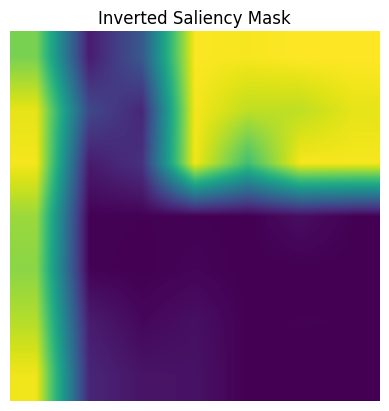

In [49]:
# Visualize Mask
_, _, _, _, mask = build_dfnet_model(video_input)  # define model
model_saliency = tf.keras.Model(inputs=video_input, outputs=mask)

# Prepare sample input
sample_video = next(iter(train_ds_oulu))[0]  # shape (B, N, 224, 224, 3)
masks_val = model_saliency.predict(sample_video)

import matplotlib.pyplot as plt

# Convert to numpy if needed
if isinstance(masks_val, tf.Tensor):
    masks_val = masks_val.numpy()

import matplotlib.pyplot as plt

plt.imshow(masks_val[0, 0, :, :, :])
plt.axis("off")
plt.title("Inverted Saliency Mask")
plt.savefig("mask_sample.png", bbox_inches='tight')  # saves to disk